# CS4035 - Cyber Data Analytics
## Lab 3 

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 3 contains 4 main questions + 1 bonus. Write the code or explanation below each sub question. For the explantions, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) A PDF or a Word report for the assignment. Create a report from the plots, figures, tables and the write-up that you provide in this jupyter file. The report will be used as a proof for page limit. 
(iii) The libraries needed to run this file. 

Your peers should be able to use the readme section for instructions and be able to run this file. 

## Group Number : 42

## Student 1 
### Name : Otte van Dam
### ID : 5096790

## Student 2
### Name : Suhaib Basir
### ID : 5059151

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

In [ ]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nbformat
from tqdm import tqdm
from flexfringe import FlexFringe


nb = nbformat.read("Lab3.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

## 1. Familiarization and discretization task – 1 A4 (5 Points)

In [ ]:
# Specify the columns you want to read as strings
string_columns = ['sTos', 'dTos']

data = "dataset_lab3/dataset_10/capture20110818.binetflow"
df = pd.read_csv(data)
df1 = pd.read_csv(data, dtype={col: str for col in string_columns})
print(df1['TotPkts'].unique())
print(len(df1['TotPkts'].unique()))
print(df1.iloc[0:5])

infected_hosts = ['147.32.84.165', '147.32.84.191', '147.32.84.193','147.32.84.204', '147.32.84.205', '147.32.84.206','147.32.84.207', '147.32.84.208', '147.32.84.209']

[    4    15     3 ...   762 10581  1452]
3190
                    StartTime         Dur Proto         SrcAddr  Sport    Dir  \
0  2011/08/18 10:21:46.633335    1.060248   tcp    93.45.239.29   1611     ->   
1  2011/08/18 10:19:49.027650  279.349152   tcp  62.240.166.118   1031    <?>   
2  2011/08/18 10:22:07.160628  166.390015   tcp   147.32.86.148  58067     ->   
3  2011/08/18 10:26:02.052163    1.187083   tcp     147.32.3.51   3130     ->   
4  2011/08/18 10:26:52.226748    0.980571   tcp   88.212.37.169   3134     ->   

          DstAddr  Dport    State sTos dTos  TotPkts  TotBytes  SrcBytes  \
0   147.32.84.118   6881     S_RA    0    0        4       252       132   
1   147.32.84.229  13363  SRPA_PA    0    0       15      1318       955   
2  66.235.132.232     80    SR_SA    0    0        3       212       134   
3    147.32.84.46  10010     S_RA    0    0        4       244       124   
4   147.32.84.118   6881     S_RA    0    0        4       244       124   

         

In [ ]:
df1 = pd.read_csv(data, dtype={col: str for col in string_columns})
df1['bytes_per_second'] = df1['TotBytes'] / df1['Dur']

# Use the value_counts() function to count the occurrences of each value in the 'SrcAddr' column
srcaddr_counts = df1['SrcAddr'].value_counts()

# Get the most occurring value by accessing the first element of the resulting series
most_common_value = srcaddr_counts.index[0]

# Print the most occurring value
print("Most occurring value in 'SrcAddr':", most_common_value, ' with ', srcaddr_counts[0], ' occurences, out of ', len(df1), ' occurences in total')

print(df1['TotPkts'].unique())
print(len(df1['TotPkts'].unique()))

df1_infected = df1[df1['SrcAddr'].isin(infected_hosts)]
df1_not_infected = df1[~df1['SrcAddr'].isin(infected_hosts)]

print(len(df1_infected), len(df1_not_infected), len(df1))

# Discretize numeric columns using percentiles
for column in df1.columns:
    if df1[column].dtype == np.float64 or df1[column].dtype == np.int64:
        df1[column] = pd.qcut(df1[column], q=10, labels=False, duplicates='drop')

# print lens of all the columns
for column in df1.columns:
    if df1[column].dtype == np.float64 or df1[column].dtype == np.int64:
        print("Column '{}' has {} unique values".format(column, len(df1[column].unique())))
        print(df1[column].unique())


Most occurring value in 'SrcAddr': 147.32.84.138  with  211967  occurences, out of  1309791  occurences in total
[    4    15     3 ...   762 10581  1452]
3190
95967 1213824 1309791


c:\python39\lib\site-packages\numpy\lib\function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Column 'Dur' has 10 unique values
[7 8 9 0 5 1 6 4 2 3]
Column 'TotPkts' has 5 unique values
[1 3 2 0 4]
Column 'TotBytes' has 9 unique values
[3 6 1 2 4 0 7 5 8]
Column 'SrcBytes' has 9 unique values
[4 6 5 0 7 1 8 2 3]
Column 'bytes_per_second' has 10 unique values
[2 0 1 9 4 5 3 6 7 8]


### 1a. Plot visualizations - Select and visualize two features for modeling the behavior of the infected host.

In [4]:
# Filter columns that are either integers or floats
numeric_cols_infected = df1[df1['SrcAddr'] == infected_hosts[0]].select_dtypes(include=['int', 'float'])
numeric_cols_other = df1[df1['SrcAddr'] != infected_hosts[0]].select_dtypes(include=['int', 'float'])

# Calculate the average and standard deviation for df_srcaddr_147
avg_values_147 = numeric_cols_infected.mean()
std_values_147 = numeric_cols_infected.std()
print(f'calculated for 147')

# Calculate the average and standard deviation for df_srcaddr_other
avg_values_other = numeric_cols_other.mean()
std_values_other = numeric_cols_other.std()
print('calculated for other')

# Print the average and standard deviation side by side
print(f"{'Column':<15} {'Average (147)':<15} {'Std Deviation (147)':<20} {'Average (Other)':<15} {'Std Deviation (Other)':<20}")
print("-" * 90)
for column in avg_values_147.index:
    avg_147 = avg_values_147[column]
    std_147 = std_values_147[column]
    avg_other = avg_values_other[column]
    std_other = std_values_other[column]
    print(f"{column:<15} {avg_147:<15.2f} {std_147:<20.2f} {avg_other:<15.2f} {std_other:<20.2f}")

calculated for 147
calculated for other
Column          Average (147)   Std Deviation (147)  Average (Other) Std Deviation (Other)
------------------------------------------------------------------------------------------
Dur             0.89            2.68                 4.52            2.86                
TotPkts         0.17            0.74                 0.94            1.40                
TotBytes        5.24            0.77                 3.59            2.62                
SrcBytes        6.18            0.64                 3.66            2.53                
bytes_per_second 8.16            2.53                 4.47            2.86                


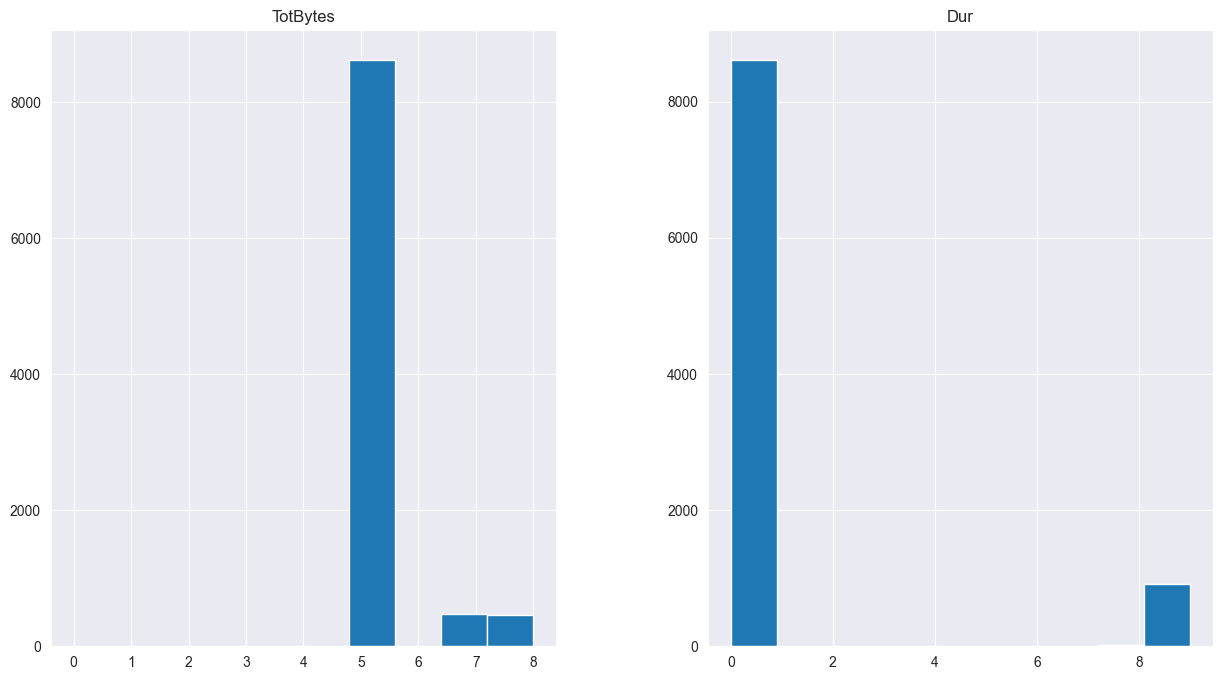

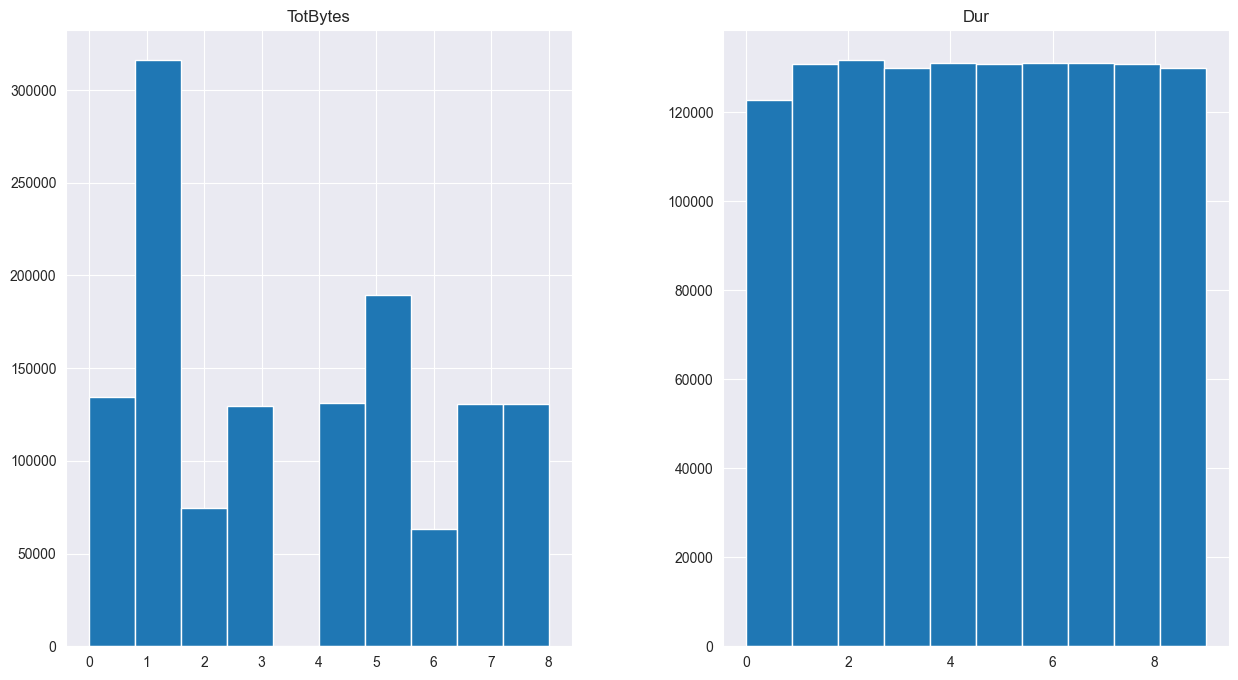

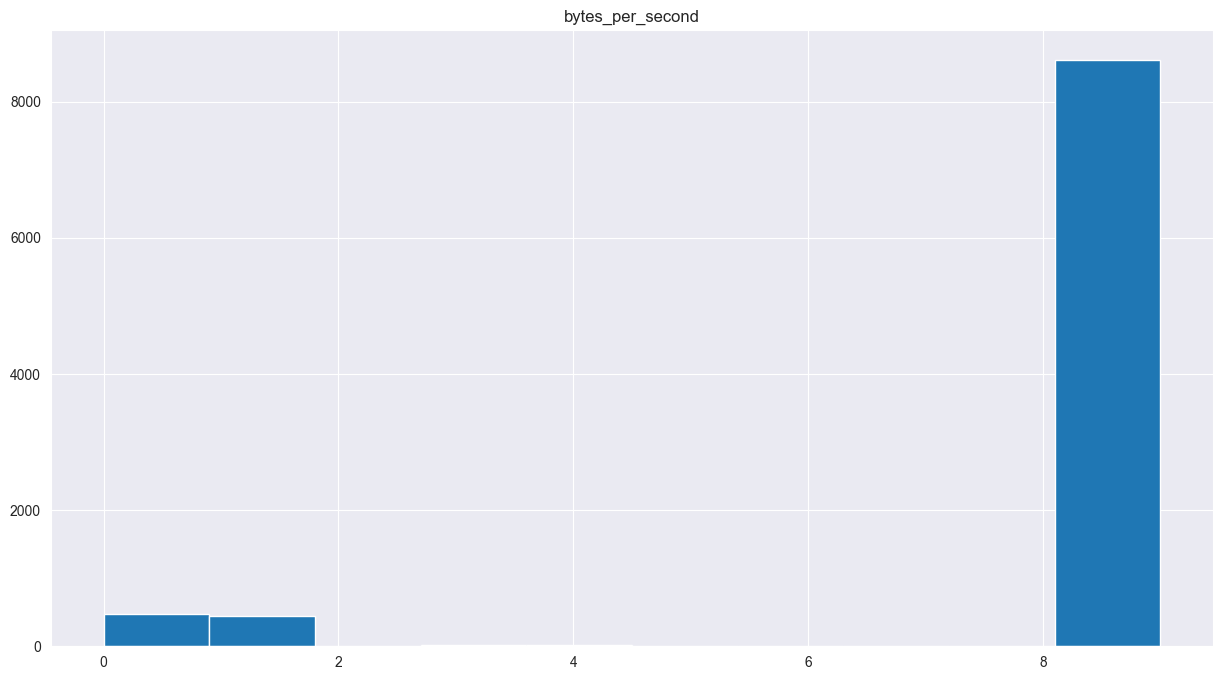

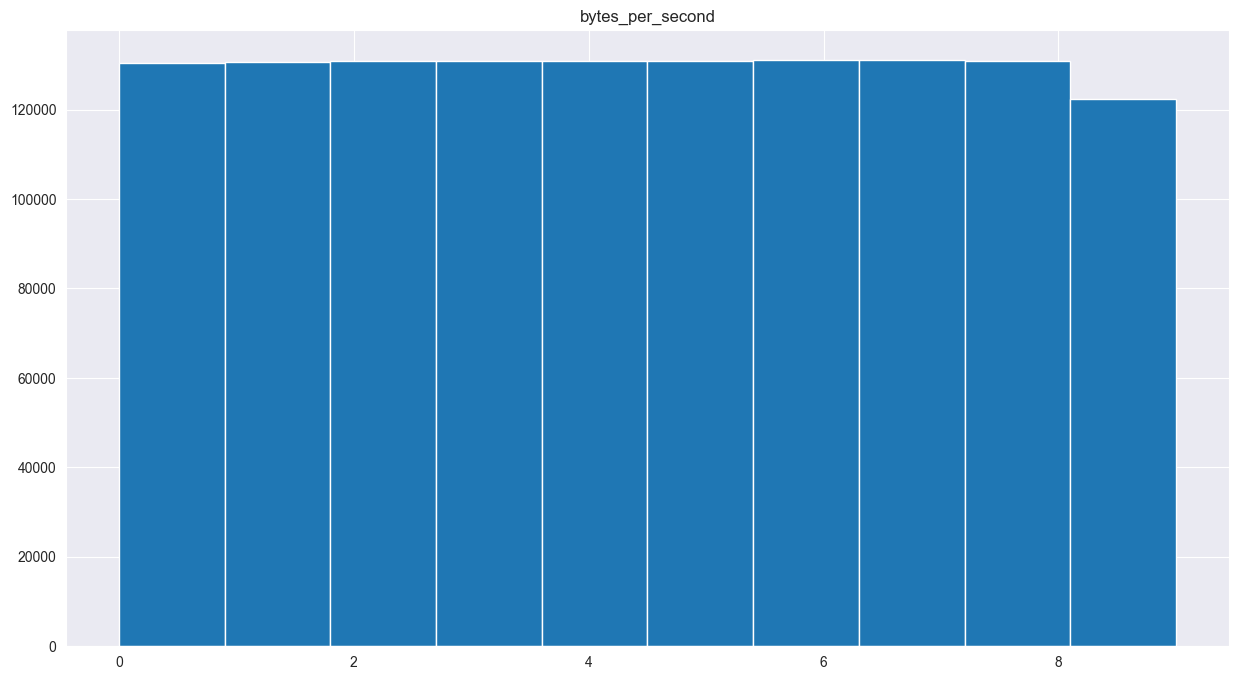

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# df1['bytes_per_second'] = df1['TotBytes'] / df1['Dur']

# Let's start by visualizinwg the 'TotBytes' and 'TotPkts' features
numeric_cols_infected[['TotBytes', 'Dur']].hist(bins=10, figsize=(15, 8))
plt.show()

numeric_cols_other[['TotBytes', 'Dur']].hist(bins=10, figsize=(15, 8))
plt.show()

numeric_cols_infected[['bytes_per_second']].hist(bins=10, figsize=(15, 8))
numeric_cols_other[['bytes_per_second']].hist(bins=10, figsize=(15, 8))
plt.show()


### 1b. Discretize selected features

### 1c. Answers and explanation

## 2. Sketching task – 1/2 A4 (Individual, 10 Points)

### 2a. COUNT-MIN sketch


### 2b. Analysis and answers to the questions

## 3. Min-wise locality sensitive hashing task – 1/2 A4 (Individual, 10 Points)

### 3a. Implementation

### 3b. Analysis and answers to the questions

## 4.Botnet profiling and fingerprinting task – 1 A4 (5 Points)

### 4a. Learn a sequential model, profiling and fingerprinting

In [13]:
df_tracefile = df1[:200000]
df_tracefile['eval'] = df_tracefile['SrcAddr'].isin(infected_hosts).astype(int)
# Filter out rows where 'SrcAddr' appears less than 20 times
df_tracefile = df_tracefile.groupby('SrcAddr').filter(lambda x: len(x) >= 30)
df_tracefile = df_tracefile.groupby('DstAddr').filter(lambda x: len(x) >= 30)
df_tracefile = df_tracefile.rename(columns={"bytes_per_second": "symb"}).rename(columns={"SrcAddr": "id"})[['id', 'symb', 'eval']]
print(len(df_tracefile))
flexfringe = FlexFringe(
    flexfringe_path="flexfringe-x64-windows.exe",
    heuristic_name="alergia",
    data_name="alergia_data",
    slidingwindow=1,
    swsize=10,
    sinkson=1,
    sinkcount=50,
    printblue=1
)
print('Loaded flexfringe')
# Learn a state machine
flexfringe.fit(df_tracefile,
               sinkson=1,
               sinkcount=50)
print('fitted')
# Use state machine to predict likelihoods
df = flexfringe.predict(df_tracefile)
flexfringe.show()

print(df['state sequence'])

C:\Users\ottev\AppData\Local\Temp\ipykernel_8100\3065241543.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tracefile['eval'] = df_tracefile['SrcAddr'].isin(infected_hosts).astype(int)


114146
Loaded flexfringe
fitted


c:\python39\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (116529190 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


row nr
10         [2, 17, 90, 368, 368, 368, 368, 368, 368, 368]
17         [2, 17, 90, 368, 368, 368, 368, 368, 368, 368]
30         [2, 17, 90, 368, 368, 368, 368, 368, 368, 368]
43         [2, 17, 90, 368, 368, 368, 368, 368, 368, 368]
48         [2, 17, 90, 368, 368, 368, 368, 368, 368, 368]
                               ...                       
114122      [4, 34, 159, 158, 34, 159, 497, 1280, 45, 33]
114127         [6, 8, 45, 203, 33, 158, 497, 158, 33, 34]
114133        [4, 8, 44, 44, 1280, 33, 158, 33, 158, 158]
114139         [5, 4, 33, 158, 158, 497, 33, 34, 34, 159]
114144    [8, 1280, 34, 34, 159, 159, 159, 159, 158, 497]
Name: state sequence, Length: 22596, dtype: object


### 4b. Analysis and answers to the questions.

       abbadingo type abbadingo length  \
row nr                                   
9                   0               10   
14                  0               10   
19                  0               10   
24                  0               10   
29                  0               10   

                                          abbadingo trace  \
row nr                                                      
9       [0/0, 2/0, 1/0, 1/0, 1/0, 1/0, 1/0, 1/0, 1/0, ...   
14      [1/0, 1/0, 1/0, 1/0, 1/0, 1/0, 1/0, 1/0, 1/0, ...   
19      [1/0, 1/0, 1/0, 1/0, 1/0, 1/0, 1/0, 1/0, 1/0, ...   
24      [1/0, 1/0, 1/0, 1/0, 1/0, 2/0, 1/0, 1/0, 1/0, ...   
29      [2/0, 1/0, 1/0, 1/0, 1/0, 1/0, 1/0, 2/0, 0/0, ...   

                                        state sequence  \
row nr                                                   
9          [1, 12, 3, 17, 36, 128, 743, 743, 743, 743]   
14      [3, 17, 36, 128, 743, 743, 743, 743, 743, 743]   
19      [3, 17, 36, 128, 743, 743, 743, 743, 

## 5. Bonus Task 1/2 A4 (5 Points)

### 5a. Provide implementation and analysis.